In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
# 处理二分类的问题

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
X = data['data']
Y = data['target']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, 
                                                test_size = 0.3
                                                ,random_state = 5  # 5最优
                      )

In [108]:
# 使用xgboost原生的包
# 将数据转化成xgboost自己能读懂的数据结构

dtrain = xgb.DMatrix(Xtrain, Ytrain, feature_names = data['feature_names'])
dtest = xgb.DMatrix(Xtest, Ytest, feature_names = data['feature_names'])

# 参数字典设置

params = {
    'objective' : 'binary:logistic', #目标函数，逻辑回归，predict输出为类概率
    'booster' : 'gbtree', #基分类器的种类
    'eta' : 0.01, # 学习率
    'max_depth' : 6, #基分类器最大深度
    'gamma' : 0, # 后剪枝
    'min_child_weight' : 1, 
    'subsample' : 0.8, # 行的有放回采样，70%
    'colsample_bytree' : 1, # 列无放回采样， 90%
    'lambda' : 0.3,
    'eval_metric' : ['error', 'auc'] # 指定我们在训练的过程当中，将训练集和测试集上的auc和error计算出来
}


# 尝试自己调整这些参数，看下在测试集上的分数

# 设置一下watchlist
watch_list = [(dtrain, 'train'), (dtest, 'test')]

# 从而使得xgboost在拟合训练集的时候，不仅是不断提升训练集上的分数，而且也同时观测测试机上的分数
model = xgb.train(params, dtrain, num_boost_round = 1000,
                  evals = watch_list, # 查看每一次迭代在训练集上的分数与预测集上的分数
                  early_stopping_rounds = 30, # 查看在迭代过程中，对evals中最后一个做测试，如果指标没有提升，则迭代停止
                  verbose_eval = False
                 )

# 默认的使用watch_list里面的最后一个元素做测试的数据集
# 默认的使用eval_metric里面最优一个元素做评估指标
# 如果评估指标在最后10次迭代当中，没有一个明显的提升，就停止迭代

# 开始训练模型， 训练模型的过程中，可以尝试设置很大的基分类器的个数
# 并且通过设置'提前停止'的条件从而使得迭代提早停止


In [95]:
# 模型给出的是一个概率值
def prob_to_label(pred, threshold = 0.5):
    return (pred >= threshold).astype(int)

threshold = 0.5
Ytrain_pred = prob_to_label(model.predict(dtrain), threshold = threshold)
Ytest_pred = prob_to_label(model.predict(dtest), threshold = threshold)

# 借助sklearn里面算准确率的一个包，来真实标签值，和预测标签值的一个准确率
from sklearn.metrics import accuracy_score

print(accuracy_score(Ytrain, Ytrain_pred), accuracy_score(Ytest, Ytest_pred))

# 做一个混淆矩阵
from sklearn.metrics import confusion_matrix as CM
CM_df = pd.DataFrame(CM(Ytest, Ytest_pred, labels = (1, 0)), 
                     index = ['实际为1','实际为0'], 
                     columns = ['预测为1', '预测为0'])
CM_df['TPR_FPR'] = CM_df['预测为1'] / CM_df.sum(axis = 1)
CM_df

# 尝试自己更改threshold的值
# 如果一个模型是好的模型，预测出来的类概率的结果应该是这个样子的
# [0.01, 0.01, 0.01, 0.999, 0.998, 0.997]
# 所以会发现threshold值变化不会影响TPR和FPR的值，并且TPR的值约等于1， FPR的值约等于0
# 为什么结果(TPR,FPR)始终都大约为（0，1），从混淆矩阵看，大多数的样本全部在对角线上

# 相反的看，一个比较差的模型，
# [0.3, 0.4, 0.6, 0.7, 0.9]
# 所以会发现threshold值变化很可能会非常影响TPR和FPR的值
# (TPR,FPR)不为（0，1）

1.0 0.9824561403508771


,预测为1,预测为0,TPR_FPR
实际为1,110,0,1.00000
实际为0,3,58,0.04918


In [109]:
# 画出一个模型的auc
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(Ytest, model.predict(dtest))
auc(fpr, tpr)

0.9894187779433681

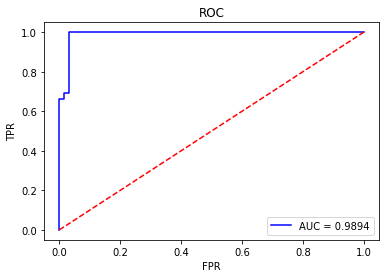

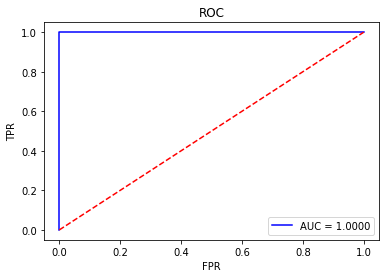

In [110]:
# 尝试定义一rocauc个函数
import matplotlib.pyplot as plt

def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

plot_roc(Ytest, model.predict(dtest))
plot_roc(Ytrain, model.predict(dtrain))

In [115]:
# 如何使用xgboost的交叉验证，当前是xgboost原生的包，无法使用cross_validate_score
#cross_val_score(model, X, Y)


# 在做交叉验证的时候也可以尝试设置评估指标，通过评估指标，来在适当的时候停止迭代
# 并且将交叉验证在训练集上的分数和测试集上的分数全都打印出来

xgb.cv(params, dtrain, 1000, nfold = 5,
       callbacks = [xgb.callback.early_stop(30),
                    xgb.callback.print_evaluation(show_stdv = False), # 不想看标准差
                   ]
      )

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 30 rounds.
[0]	train-error:0.03455	train-auc:0.99414	test-error:0.08035	test-auc:0.95772
[1]	train-error:0.01759	train-auc:0.99811	test-error:0.07038	test-auc:0.96620
[2]	train-error:0.02073	train-auc:0.99847	test-error:0.06288	test-auc:0.97683
[3]	train-error:0.01821	train-auc:0.99871	test-error:0.05528	test-auc:0.97936
[4]	train-error:0.02010	train-auc:0.99908	test-error:0.06032	test-auc:0.98187
[5]	train-error:0.01947	train-auc:0.99917	test-error:0.06032	test-auc:0.98256
[6]	train-error:0.01633	train-auc:0.99926	test-error:0.06535	test-auc:0.98270
[7]	train-error:0.01570	train-auc:0.99930	test-error:0.06282	test-auc:0.98238
[8]	train-error:0.01822	train-auc:0.99921	test-error:0.06282	test-auc:0.98272
[9]	train-error:0.01696	train-auc:0.99923	test-error:0.06278	test-auc:0.98217
[10]	train-error:0.01758	train-auc:0.99925	test-error:0.05775	test-auc:0.98251


,train-error-mean,train-error-std,train-auc-mean,train-auc-std,test-error-mean,test-error-std,test-auc-mean,test-auc-std
0,0.034554,0.006623,0.994144,0.002720,0.080348,0.027990,0.957722,0.016302
1,0.017592,0.007068,0.998108,0.001019,0.070380,0.017074,0.966204,0.011239
2,0.020729,0.009453,0.998474,0.001019,0.062880,0.022577,0.976834,0.011919
3,0.018209,0.008739,0.998707,0.000764,0.055285,0.016992,0.979359,0.012419
4,0.020096,0.004241,0.999083,0.000394,0.060316,0.021583,0.981868,0.009897
5,0.019471,0.003653,0.999171,0.000361,0.060316,0.021583,0.982555,0.009737
6,0.016327,0.006080,0.999259,0.000283,0.065348,0.014686,0.982699,0.009918
7,0.015698,0.005604,0.999301,0.000283,0.062817,0.028619,0.982382,0.009898
8,0.018215,0.004156,0.999209,0.000239,0.062817,0.028619,0.982715,0.009888
9,0.016961,0.004260,0.999225,0.000142,0.062785,0.034555,0.982172,0.009733


In [121]:
# 记录交叉验证的结果，将Dataframe放入一个变量当中
cross_results = xgb.cv(params, dtrain, 1000, nfold = 5,
                       callbacks = [xgb.callback.early_stop(30),
                                    #xgb.callback.print_evaluation(show_stdv = False), # 不想看标准差
                                   ])

cross_results['test-auc-mean'].values[-1]

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 30 rounds.
Stopping. Best iteration:
[15]	train-error:0.01256+0.00627	train-auc:0.99939+0.00027	test-error:0.05522+0.02571	test-auc:0.98687+0.00807



0.9868694

In [123]:
# 可以尝试使用测试集迭代完之后的模型来进行参数的调优，我们可以使用以下的方式
params = {
    'objective' : 'binary:logistic',#目标函数，逻辑回归，predict输出为类概率
    #'objective' : 'binary:logitraw',#目标函数，逻辑回归，给出的是做sigmod转换之前的值
    'booster' : 'gbtree',#基分类器的种类
    'eta' : 0.1,#学习率,默认值是0.1
    'gamma' : 0,#后剪枝的过程,0到正无穷, 默认0，尝试0, 1，5，10，100
    'min_child_weight':1,#叶子节点权重分数的下界
    'max_depth': 5, #最大深度
    'eval_metric' : ['auc','error']
}

d_list = []
for d in range(1, 10):
    params['max_depth'] = d
    cross_results = xgb.cv(params, dtrain, 1000, nfold = 5,
                       callbacks = [xgb.callback.early_stop(30),
                                    #xgb.callback.print_evaluation(show_stdv = False), # 不想看标准差
                                   ])
    d_list.append(cross_results['test-auc-mean'].values[-1])

Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 30 rounds.
Stopping. Best iteration:
[37]	train-auc:0.99625+0.00062	train-error:0.02512+0.00523	test-auc:0.98293+0.00821	test-error:0.05775+0.03669

Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 30 rounds.
Stopping. Best iteration:
[79]	train-auc:1.00000+0.00000	train-error:0.00063+0.00125	test-auc:0.98938+0.00678	test-error:0.04269+0.02923

Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 30 rounds.
Stopping. Best iteration:
[46]	train-auc:1.00000+0.00000	train-error:0.00126+0.00154	test-auc:0.98657+0.00758	test-error:0.04772+0.02428

Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 30 rounds.
Stoppi

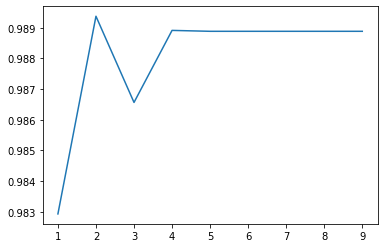

In [124]:
# 将图给画出来
plt.plot(range(1, 10), d_list)

In [129]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [131]:
# 尝试使用随机森林，查看这份数据集下，随机森林得出的结果
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100)
cross_val_score(rfc, Xtrain, Ytrain, cv = 10, scoring = 'roc_auc').mean()

0.9896111111111111

In [143]:
# xgboost的原生的包不能放入gridsearchcv进行调参, 不好调参
# 但是xgboost也提供了sklearn的API
# 小试牛刀一下XGBClassifier
# 尝试使用cross_validate_score

from xgboost import XGBClassifier
model = XGBClassifier(n_estimators = 1000)
model.fit(Xtrain, Ytrain,
          early_stopping_rounds = 20, # 设置什么时候停止
          eval_metric = 'auc', # 评估指标为'error', 稍后尝试auc
          eval_set = [(Xtest, Ytest)], # 设置是在什么数据集上查看auc是否持续增加
          verbose = 0
         )

model.score(Xtrain, Ytrain), model.score(Xtest, Ytest)
#cross_val_score(model, Xtrain, Ytrain, cv = 10, scoring = 'roc_auc').mean()

(1.0, 0.9824561403508771)

In [9]:
# 实例化详细的了解一下fit方法
# 在fit里面也是可以尝试使用的参数, 查看作重要的几个
# eval_set, 在训练的过程当中，也可以查看在训练集上的分数和测试集上的分数
# eval_metric, 到底使用什么指标来进行计算
# early_stopping_rounds, 在eval_set最后一个元素上，检测每一次跌倒的分数
# 如果在指定的次数内，eval_metric的分数没有一个较大的提升，就终止迭代
# verbose, 指的是是否要打印出每一次迭代的分数

In [151]:
# 这个时候由于是sklearn的API，则可以使用grid_search_cv来做网格搜索了
# 每个参数的范围，可以尝试通过每个参数的学习曲线去找

In [152]:
# 将grid_search_cv的参数放入原生的xgb里面进行计算
from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(n_estimators = 1000)
grid = {
    'max_depth' : [4,5,6],
    'gamma' : [0,1,2,3],
    'learning_rate' : [0.05, 0.1, 0.2],
    'min_child_weight': [1,2,3,4],
    'subsample' : [0.7, 1], # 行的有放回采样，70%
    'colsample_bytree' : [0.7, 1], # 列无放回采样， 90%
}

# model加载进去之后，model里面所有的功能，全部都会继承给clf_grid, 这个时候，可以近似将clf_grid看出xgboost模型
# xgboost里面方法，里面的参数，clf_grid
clf_grid = GridSearchCV(model, grid, cv = 5)


clf_grid.fit(Xtrain, Ytrain,
             early_stopping_rounds = 20, # 设置什么时候停止
             eval_metric = 'auc', # 评估指标为'error', 稍后尝试auc
             eval_set = [(Xtest, Ytest)], # 设置是在什么数据集上查看auc是否持续增加
             verbose = 0
            )

print(clf_grid.best_params_, clf_grid.best_score_)
print(clf_grid.score(Xtrain, Ytrain), clf_grid.score(Xtest, Ytest))

{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1} 0.959746835443038
1.0 0.9824561403508771


In [154]:
#{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1} 0.9673366834170855
# 1.0 0.9883040935672515

In [155]:
# 使用grid_search_cv后的参数，直接放入xgb原生的包之中看下最后结果

dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)

params = {
    'objective' : 'binary:logistic',#目标函数，逻辑回归，predict输出为类概率
    #'objective' : 'binary:logitraw',#目标函数，逻辑回归，predict输出为sigmod转换前的值
    'booster' : 'gbtree',#基分类器的种类
    'eta' : 0.2,#学习率,默认值是0.1
    'gamma' : 0,
    'min_child_weight':1,#叶子节点权重分数的下界
    'max_depth': 4, #最大深度
    'eval_metric' : ['auc','error'],
    'colsample_bytree': 0.7,
    'subsample': 1
}

model = xgb.train(params, dtrain, 100, 
                  #watch_list
                 )
Ytrain_pred = prob_to_label(model.predict(dtrain))
Ytest_pred = prob_to_label(model.predict(dtest))
accuracy_score(Ytrain, Ytrain), accuracy_score(Ytest, Ytest_pred)

(1.0, 0.9824561403508771)

In [169]:
# 查看每一个数的结构
tree = model.trees_to_dataframe()
tree[tree['Tree'] == 99]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
727,99,0,99-0,f24,0.1364,99-1,99-2,99-1,0.071276,2.626288
728,99,1,99-1,Leaf,NaN,NaN,NaN,NaN,0.023289,1.405666
729,99,2,99-2,Leaf,NaN,NaN,NaN,NaN,-0.026404,1.220622


In [164]:
#model.get_fscore()

In [162]:
# 查看特征重要性
importance = model.get_fscore()
importance_new = {i : [importance[i]] for i in importance}
importance_df = pd.DataFrame(importance_new).T.reset_index()
importance_df.columns = ['features', 'feature_importance']
importance_df['feature_importance'] = importance_df['feature_importance']/importance_df['feature_importance'].sum()
importance_df.sort_values(by = 'feature_importance', ascending = False)

,features,feature_importance
5,f1,0.111111
14,f21,0.101587
9,f13,0.082540
7,f23,0.079365
16,f7,0.066667
11,f26,0.060317
1,f24,0.057143
8,f27,0.053968
12,f4,0.050794
17,f20,0.047619


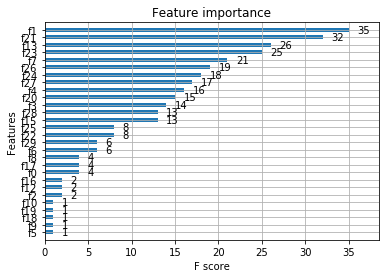

In [165]:
# 画出特征重要性
xgb.plot_importance(model, ax = None, height = 0.5)

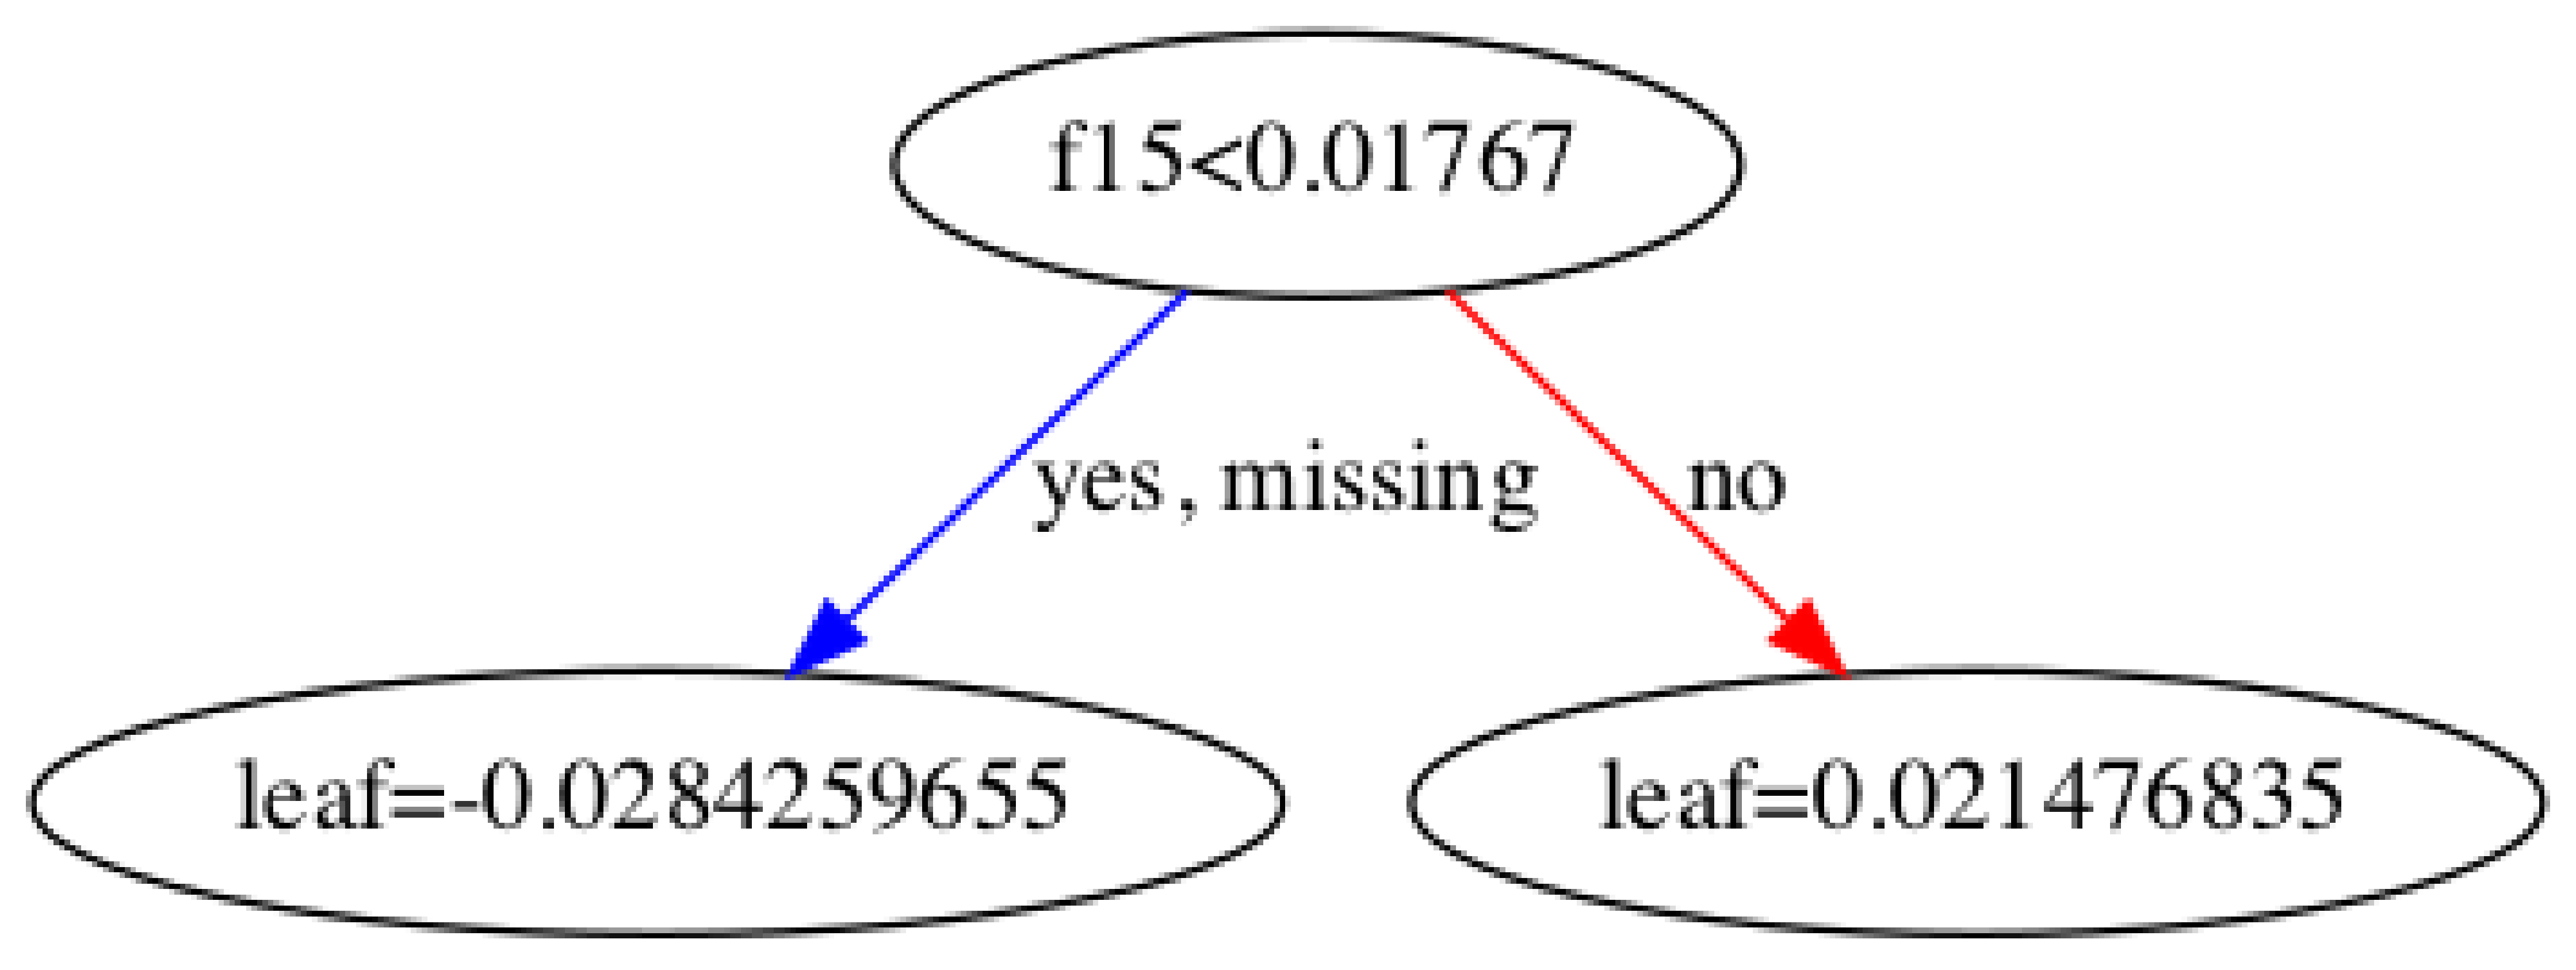

In [170]:
# 每一个树的可视化
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

xgb.plot_tree(model, num_trees = -2)

In [172]:
# 将最后的结果保存下来，每一个数具体的信息就可以保存txt当总
# 这种txt文件可以后期进行一些处理，将其转换成sql语句，作用于数据库中

model.dump_model('try.txt')

In [173]:
# 如何来保存模型，有两种方法

# 第一种是直接使用.save_model的方式
model.save_model('model_save.model')

In [177]:
# 加载模型
model = xgb.Booster()
model.load_model('model_save.model')
#model.predict(dtrain)

In [178]:
# 第二种比较常用，使用的是pickle的方式来保存
# pickle几乎能保存所有可能的类

import pickle

#首先要打开一个文件，然后将模型写进去
#如果是要写一个二进制文件的话，就需要用wb, write binary在写入
pickle.dump(model, open('xgb.bat', 'wb'))

#从二进制文件读取模型, r read
model = pickle.load(open('xgb.bat', 'rb'))
#调用出来之前上模型来预测数据

In [179]:
# 多分类问题的,小麦种子的案例
# https://archive.ics.uci.edu/ml/machine-learning-databases/00236/
data = pd.read_csv('seeds_dataset.txt', 
                   header = None,
                   sep = '\s+'
                  )
data.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [180]:
# 取出数据集里的X与Y
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

# 查看Y的标签
Y.value_counts()


# 这个时候观测到数据集的标签是从1打头的

3    70
2    70
1    70
Name: 7, dtype: int64

In [182]:
# 对于多分类的问题来说
# 需要更改objective为multi:softmax, 也需要指定num_class

d = xgb.DMatrix(X, Y)

# 尝试设置简单的params来拟合数据
params = {
    'objective' : 'multi:softmax',
    'num_class' : 3,
    'eta' : 0.1,
    'max_depth' : 5,
}


# 尝试开始训练数据
# xgb.train(params, d, num_boost_round = 10)

# 这个时候会报错，报错的信息提示label里面必须是从0开始的，但是当前的标签是从1开始的

# 所以需要将label里面的值减一个
Y = Y - 1

In [184]:
# 按正常的方式来切分数据集

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, 
                                                test_size = 0.3
                                                ,random_state = 5  # 5最优
                      )

dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)

In [191]:
# 设置多分类问题的参数，并且拟合数据
params = {
    'objective' : 'multi:softmax',  #类似于sigmod,可以将多分类的预测值映射到0到1之间，通过softmax函数解决多分类问题
    #'objective' : 'multi:softprob', #类似于predict_prob，给出每个样本在每个类别下下的预测概率
    'num_class' : 3,   # 必须告知字典，当前数据集里Y标签的种类有多少
    'eval_metric' : ['merror', 'mlogloss'],
    'eta' : 0.1,       # 学习率
    'max_depth' : 5,   # 树的最大深度
    'gamma' : 0,#后剪枝的过程,0到正无穷, 默认0，尝试0, 1，5，10，100
    'min_child_weight':1,#叶子节点权重分数的下界
}

watchlist = [(dtrain, 'train'),(dtest, 'test')]
model = xgb.train(params, dtrain, 1000, 
                  watchlist, 
                  early_stopping_rounds = 10,
                  verbose_eval = False
                 )

In [193]:
# softmax是直接给出预测的标签值，不是类概率
# model.predict(dtrain)

# 可以直接使用sklearn的accuracy_score方法来计算准确度

Y_train_pred = model.predict(dtrain)
Y_test_pred = model.predict(dtest)  # 由于设定的是softmax，所以给出的结果直接是label, 可以尝试改成softprob
accuracy_score(Ytrain, Y_train_pred), accuracy_score(Ytest, Y_test_pred)

(1.0, 0.9365079365079365)

In [194]:
# 模型表现不怎么样，xgboost不行的话，看一下rfc和ada的表现呢
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


rfc = RandomForestClassifier(n_estimators = 100).fit(Xtrain, Ytrain)
print(rfc.score(Xtrain, Ytrain), rfc.score(Xtest, Ytest))

DTC = DecisionTreeClassifier(max_depth = 5)
adc = AdaBoostClassifier(base_estimator = DTC, n_estimators = 200).fit(Xtrain, Ytrain)
print(adc.score(Xtrain, Ytrain), adc.score(Xtest, Ytest))

# 发现rfc和ada表现都不咋滴，还是xgboost略微高一些

1.0 0.9206349206349206
1.0 0.8888888888888888


In [197]:
# 小试牛刀尝试使用sklearn的API
model = XGBClassifier(n_estimators = 100)
model.fit(Xtrain, Ytrain,
          early_stopping_rounds = 10,  # 设置什么时候停止
          eval_metric = 'mlogloss',         # 评估指标为'merror'，或者mlogloss
          eval_set = [(Xtest, Ytest)],  # 设置是在什么数据集上查看mlogloss是否持续增加
          verbose = 0
         )
model.score(Xtrain, Ytrain), model.score(Xtest, Ytest)

(1.0, 0.9523809523809523)

In [198]:
# 开始设置一些参数的范围，开始网格搜索
model = xgb.XGBClassifier(n_estimator = 100)
grid = {
    'max_depth' : range(3, 10),
    'gamma' : [0,1,2],
    'learning_rate' : [0.1, 0.2],
    'min_child_weight': [1,2,3],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'subsample' : [0.7, 1]
}

clf_grid = GridSearchCV(model, grid, cv = 10)
clf_grid.fit(Xtrain, Ytrain,
             early_stopping_rounds = 10,  # 设置什么时候停止
             eval_metric = 'mlogloss',         # 评估指标为'merror'，或者mlogloss
             eval_set = [(Xtest, Ytest)],  # 设置是在什么数据集上查看mlogloss是否持续增加
             verbose = False
            )
# clf_grid.get_xgb_params()
print(clf_grid.best_params_, clf_grid.best_score_)
print(clf_grid.score(Xtrain, Ytrain), clf_grid.score(Xtest, Ytest))

KeyboardInterrupt: 

In [199]:
# 设置多分类的参数，使用xgboost原生的包

# 设置多分类问题的参数
params = {
    'objective' : 'multi:softmax',  #类似于sigmod,可以将多分类的预测值映射到0到1之间，通过softmax函数解决多分类问题
    #'objective' : 'multi:softprob', #类似于predict_prob，给出每个样本在每个分类下的预测概率
    'num_class' : 3,   # 必须告知字典，当前数据集里Y标签的种类有多少
    'eval_metric' : ['merror', 'mlogloss'],
    'eta' : 0.2,       # 学习率
    'max_depth' : 4,   # 树的最大深度
    'gamma' : 0,#后剪枝的过程,0到正无穷, 默认0，尝试0, 1，5，10，100
    'min_child_weight':2,#叶子节点权重分数的下界
    'colsample_bytree':0.6
}

watchlist = [(dtrain, 'train'),(dtest, 'test')]
model = xgb.train(params, dtrain, 1000, 
                  watchlist, 
                  early_stopping_rounds = 10,
                  verbose_eval = 0
                 )
accuracy_score(Ytrain, model.predict(dtrain)), accuracy_score(Ytest, model.predict(dtest))

(1.0, 0.9523809523809523)

In [241]:
# 回归类问题

from xgboost import XGBRegressor
import warnings
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error as MSE, r2_score

#导入数据并且切分数据集
data = load_boston()
X = data.data
Y = data.target

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.3
                                                , random_state = 420
                                               )
dtrain = xgb.DMatrix(Xtrain, Ytrain)
dtest = xgb.DMatrix(Xtest, Ytest)

In [231]:
# 使用sklearnAPI实例化模型
model = XGBRegressor(n_estimator = 100).fit(Xtrain, Ytrain)
model.score(Xtrain, Ytrain), model.score(Xtest, Ytest)

(0.9999980988030761, 0.9050988954757183)

In [232]:
# 线性回归模型的结果
from sklearn.linear_model import LinearRegression

LR = LinearRegression().fit(Xtrain, Ytrain)
LR.score(Xtrain, Ytrain), LR.score(Xtest, Ytest)

(0.7279250285365977, 0.7550352352974805)

In [233]:
# 和随机森林回归来比较
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100).fit(Xtrain, Ytrain)
rfr.score(Xtrain, Ytrain), rfr.score(Xtest, Ytest)

(0.9787439977029202, 0.8965561766664698)

In [234]:
# cv

#print(cross_val_score(model, X, Y, cv = 10, scoring = 'r2'))
#print(cross_val_score(rfr, X, Y, cv = 10, scoring = 'r2'))

In [242]:
# 使用类DMatrix读取数据, 特征矩阵和标签进行一起传入

# 并且这里也介绍一些新的参数 
# colsample_bytree 列的随机采样
# subsample bootstrap样本的有放回随机采样

params = {
    'objective':'reg:linear',#目标函数，线性回归
    'subsample':1,   #训练样本的抽样比例 防止过拟合
    'eta' : 0.3, #学习率     默认0.3，一般低于0.3
    'gamma': 0, #后剪枝的过程    0到正无穷
    'lambda':1, #控制模型复杂度的权重值的L2的正则化，参数越大，越不容易过拟合，默认1
    'max_depth':5, #控制几分类器的深度，越大越过拟合， 默认6， 决策树里面默认5
    'colsample_bytree':1, #生成树的列采样：无放回  默认1
    'min_child_weight':1, #叶子节点权重分数的下界
    'silent' : True, #不显示warning
    'nthread': 4,   #CPU的线程数，分布并行处理
    'eval_metric' : ['rmse'],
}

watchlist = [(dtrain, 'train'),(dtest, 'test')]

#训练模型， 可以直接导入参数，训练数据，树的数量
model = xgb.train(params, dtrain,
                  num_boost_round = 200,
                  evals = watchlist,
                  early_stopping_rounds = 10,
                  verbose_eval = 0   # 不打印中间结果
               )

In [244]:
# 计算出MSE和r2分数
print(MSE(model.predict(dtrain), Ytrain), 
      MSE(model.predict(dtest), Ytest))
print(r2_score(model.predict(dtrain), Ytrain), 
      r2_score(model.predict(dtest), Ytest))

0.16423299316386236 10.043756983348942
0.9979365342652348 0.8762796762908707


In [246]:
# 尝试使用网格搜索的方式来找最优参数
model = xgb.XGBRegressor(n_estimators = 100)
grid = {
    'max_depth' : range(3, 10),
    'gamma' : [0, 1, 2],
    'lambda' : [0, 1],
    'learning_rate' : [0.05, 0.1, 0.2],
    'min_child_weight': [1,2,3,4],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'subsample' : [0.7, 1],
}

clf_grid = GridSearchCV(model, grid, cv = 5, verbose = 0)
clf_grid.fit(Xtrain, Ytrain,
              early_stopping_rounds = 10,  # 设置什么时候停止
              eval_metric = 'rmse',         # 评估指标为'rmse'
              eval_set = [(Xtest, Ytest)],  # 设置是在什么数据集上查看mlogloss是否持续增加
              verbose = 0                   # 在测试集上测试，不打印中间结果
            )

KeyboardInterrupt: 

In [247]:
# 将最优的参数放入在原生的包里面查看最后的结果
params = {
    'obj':'reg:linear',#目标函数，线性回归
    'subsample': 0.7,   #训练样本的抽样比例 防止过拟合
    'eta' : 0.2, #学习率     默认0.3，一般低于0.3
    'gamma': 0, #后剪枝的过程    0到正无穷
    'lambda': 1, #控制模型复杂度的权重值的L2的正则化，参数越大，越不容易过拟合，默认1
    'max_depth': 9 , #控制几分类器的深度，越大越过拟合， 默认6， 决策树里面默认5
    'colsample_bytree': 0.8, #生成树的列采样：无放回  默认1
    'min_child_weight': 3, #叶子节点权重分数的下界
    'silent' : True, #不显示warning
    'nthread': 4,   #CPU的线程数，分布并行处理
    'eval_metric' : ['rmse'],
}

watchlist = [(dtrain, 'train'),(dtest, 'test')]

#训练模型， 可以直接导入参数，训练数据，树的数量
model = xgb.train(params, dtrain,
                  num_boost_round = 200,
                  evals = watchlist,
                  early_stopping_rounds = 10,
                  verbose_eval = 0   # 不打印中间结果
               )

print(MSE(model.predict(dtrain), Ytrain), 
      MSE(model.predict(dtest), Ytest))
print(r2_score(model.predict(dtrain), Ytrain), 
      r2_score(model.predict(dtest), Ytest))

0.003490252131971029 7.201718445748189
0.9999566788470385 0.9100805422908598


In [250]:
# 之前使用的是rmse来进行判定的，此时如果我们想自定义一个评估标准的话可以写一个函数出来

from sklearn.metrics import mean_squared_error as MSE, r2_score


# 定义一个计算R平方的函数，注意return记结果的格式有规则，不然xgb不认识

def evalr2(preds, dmatrix):
    R2 = r2_score(preds, dmatrix.get_label())
    if R2 <= 0 :
        R2 = 0
    return 'neg_R2', -R2


params = {
    'obj':'reg:linear',#目标函数，线性回归
    'subsample': 0.7,   #训练样本的抽样比例 防止过拟合
    'eta' : 0.2, #学习率     默认0.3，一般低于0.3
    'gamma': 0, #后剪枝的过程    0到正无穷
    'lambda': 1, #控制模型复杂度的权重值的L2的正则化，参数越大，越不容易过拟合，默认1
    'max_depth': 9 , #控制几分类器的深度，越大越过拟合， 默认6， 决策树里面默认5
    'colsample_bytree': 0.8, #生成树的列采样：无放回  默认1
    'min_child_weight': 3, #叶子节点权重分数的下界
    'silent' : True, #不显示warning
    'nthread': 4,   #CPU的线程数，分布并行处理
    #'eval_metric' : ['rmse'],
}

watchlist = [(dtrain, 'train'),(dtest, 'test')]

#训练模型， 可以直接导入参数，训练数据，树的数量
model = xgb.train(params, dtrain,
                  num_boost_round = 200,
                  evals = watchlist,
                  early_stopping_rounds = 10,
                  #verbose_eval = 0   # 不打印中间结果
                  feval = evalr2
               )

print(MSE(model.predict(dtrain), Ytrain), 
      MSE(model.predict(dtest), Ytest))
print(r2_score(model.predict(dtrain), Ytrain), 
      r2_score(model.predict(dtest), Ytest))

# 定义好函数之后，在train里面放入到feval

# 查看最后的结果

[0]	train-rmse:19.39227	test-rmse:19.58110	train-neg_R2:0.00000	test-neg_R2:0.00000
Multiple eval metrics have been passed: 'test-neg_R2' will be used for early stopping.

Will train until test-neg_R2 hasn't improved in 10 rounds.
[1]	train-rmse:15.85924	test-rmse:16.06085	train-neg_R2:0.00000	test-neg_R2:0.00000
[2]	train-rmse:12.98272	test-rmse:13.26369	train-neg_R2:0.00000	test-neg_R2:0.00000
[3]	train-rmse:10.74015	test-rmse:11.02725	train-neg_R2:0.00000	test-neg_R2:0.00000
[4]	train-rmse:8.90078	test-rmse:9.15851	train-neg_R2:0.00000	test-neg_R2:0.00000
[5]	train-rmse:7.40606	test-rmse:7.70993	train-neg_R2:0.00000	test-neg_R2:0.00000
[6]	train-rmse:6.21048	test-rmse:6.60312	train-neg_R2:0.00000	test-neg_R2:0.00000
[7]	train-rmse:5.26776	test-rmse:5.70950	train-neg_R2:-0.30493	test-neg_R2:-0.23057
[8]	train-rmse:4.49972	test-rmse:5.04421	train-neg_R2:-0.54810	test-neg_R2:-0.46284
[9]	train-rmse:3.90965	test-rmse:4.55572	train-neg_R2:-0.68542	test-neg_R2:-0.59319
[10]	train-rmse:3.3